# Imports and initialisation

In [1]:
import rospy
from robotics_demo.msg import JointPositions, Observation, AchievedGoal, PositionCommand, RPYProprioState, Velocities, ResetInfo, ToRecord, RPYState, Reengage
from robotics_demo.srv import getIK, getIKResponse, getState, getStateResponse, getTime, getTimeResponse
import time

In [2]:
import numpy as np
import os, inspect
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
AVG_MODEL_PROCESSING_TIME = 0.033
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
print("current_dir=" + currentdir)
os.sys.path.insert(0, currentdir)
from utils import rosImg_to_numpy, proprio_quat_to_rpy_vector, \
        proprio_rpy_to_ROSmsg, ag_to_vector, ag_to_ROSmsg,\
        proprio_rpy_to_rpy_vector, unstack, act_to_jointPositionsROSmsg, ServiceTimeouter


np.set_printoptions(suppress=True)

current_dir=/catkin_ws/src/robotics/unity_robotics_env/robotics_demo/scripts


In [3]:
# The publisher which sends out position commands that then get converted to joint commands by the IK node
pos_cmd_pub = rospy.Publisher('xyz_rpy_g_command', PositionCommand, queue_size=1)
# The publisher which resets the non_arm elements of the state
env_reset_pub = rospy.Publisher('full_reset', ResetInfo, queue_size=1)
env_reEngage_physics_pub = rospy.Publisher('re_engage_physics', Reengage, queue_size=1)
env_reEngage_collision_pub = rospy.Publisher('re_engage_collision', Reengage, queue_size=1)
toggleTimePub = rospy.Publisher('toggleHalt', Reengage, queue_size=1)
# The publisher which sends out the consolidated state for the saver to save
transition_pub = rospy.Publisher('timestep', ToRecord, queue_size=1)
# service to get IK 
IK = rospy.ServiceProxy('get_IK', getIK)
getStateServ = rospy.ServiceProxy('getState', getState, persistent=True)
syncTimeServ = rospy.ServiceProxy('getTime', getTime, persistent=True)

In [4]:
# First things first, lets load some data! 
DATA_PATH = os.getcwd()[:-(len("unity_robotics_env/robotics_demo/scripts"))]+'/learning_from_play/data/diverse/'
OBS_ACT_PATH = DATA_PATH+'obs_act_etc/'
IMS_PATH = DATA_PATH+'states_and_ims/'
TIME_FREQUENCY = 10
default_vr_controller_pos =  RPYProprioState(-0.4, 0.2, 0.0,0.0,0.0,0.0,0.0)
os.listdir(OBS_ACT_PATH)

['0', '1']

In [5]:
rospy.init_node('jupyter')

In [6]:

ros_shoulder_image = None
ros_gripper_image = None
    
def process_observation_srv():
    '''
    The full state will be sent out at Nh > controlHz by the env, listen to it, and save the relevant parts
    '''
    global ros_shoulder_image, ros_gripper_image
    o = getStateServ(int(1)).state
    proprioceptive_state  = proprio_quat_to_rpy_vector(o.proprio)
    achieved_goal = ag_to_vector(o.ag)
    full_state = np.concatenate([proprioceptive_state, achieved_goal])
    # process the images
    o.shoulderImage.data += (o.imq2 + o.imq3 + o.imq4)
    ros_shoulder_image = o.shoulderImage
    ros_gripper_image = o.gripperImage
    shoulder_image  = rosImg_to_numpy(ros_shoulder_image)
    gripper_image = rosImg_to_numpy(ros_gripper_image)
    velocities = o.vels
    gen_time = o.time
    return proprioceptive_state, achieved_goal, shoulder_image, gripper_image, velocities, gen_time


def check_reset_convergence(proprio, ag, current_proprio, current_ag, threshold = 0.01):
    proprio_checks = abs(proprio - current_proprio) < threshold
    ag_checks = abs(ag-current_ag) < threshold
    all_checks = np.concatenate([proprio_checks, ag_checks])
    return all_checks
#     if np.all(all_checks):
#         return True
#     else:
#         return False
    
def converge_on_reset(proprio, ag, threshold = 0.05):
    t_start = time.time()
    r = rospy.Rate(10) # 10hz 
    while not rospy.is_shutdown():
        t = time.time()
        current_arm, current_ag, _,_, _,_ = process_observation_srv()
        checks = check_reset_convergence(proprio, ag, current_arm, current_ag, threshold)
        if (t > t_start+0.1):
            idxs = np.where(checks == False)
#             print(idxs, proprio[idxs], current_arm[idxs])
            return
        elif np.all(checks):
            return
        r.sleep() # ros sleep for a little while before checking convergence again
    

In [7]:
# This is how much data we have
o, a, ag = [], [], []
for i in os.listdir(OBS_ACT_PATH):
    try:
        test = np.load(f"{OBS_ACT_PATH}/{int(i)}/data.npz", allow_pickle=True)
        obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
        o.append(obs), a.append(acts), ag.append(ags)
        print(len(obs), i)
    except:
        pass
o, a, ag = np.vstack(o), np.vstack(a), np.vstack(ag)
print(len(o)/25/60)

324 0
408 1
0.48800000000000004


In [8]:
# np.savez(OBS_ACT_PATH+'normalisation', obs_mean=o.mean(axis=0), acts_mean=a.mean(axis=0), ag_mean=ag.mean(axis=0))

In [9]:


def reset_to(arm, ag, prev_act = np.zeros(7)):
    
    arm_msg = proprio_rpy_to_ROSmsg(arm)
    #prev_act = act_to_jointPositionsROSmsg(prev_act)
    # Get IK for actual position
    prev_act = JointPositions()
    
    
    # Package into ResetInfo
    for i in range(0,2):
        joints = IK(arm_msg, prev_act).joints # once to align it with the prev acts
        r = ResetInfo(joints, ag_to_ROSmsg(ag), Velocities())
        # Send down
        env_reset_pub.publish(r)
    converge_on_reset(arm, ag, threshold = 0.05)
    env_reEngage_collision_pub.publish(Reengage())
    #time.sleep(1/TIME_FREQUENCY)
    
    

In [25]:
test = np.load(f"{OBS_ACT_PATH}/0/data.npz", allow_pickle=True)
obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
proprio = obs[:, :7]
print(len(acts))

324


# Env state subscriber
This code runs a subscriber which automatically updates these global variables while the notebook is active. Its far faster than using a service.

In [11]:
shoulder_image = None
ros_shoulder_image = None
gripper_image = None
ros_gripper_image = None
proprioceptive_state = None
achieved_goal = None
full_state = None
velocities = None
last_state_arrival_time = 0
last_state_processed_time = 0  # unless updated then the if check will fail because 0 is too long ago
last_vr_controller_time = 0
last_state_gen_time = 0

def process_observation(o: Observation):
    '''
    The full state will be sent out at Nh > controlHz by the env, listen to it, and save the relevant parts
    '''
    global shoulder_image, gripper_image, proprioceptive_state, \
            achieved_goal, full_state, last_state_arrival_time, \
            last_state_processed_time, ros_shoulder_image, ros_gripper_image, velocities, last_state_gen_time
    last_state_gen_time = o.time
    last_state_arrival_time = time.time()
    o.shoulderImage.data += (o.imq2 + o.imq3 + o.imq4)
    ros_shoulder_image = o.shoulderImage
    shoulder_image  = rosImg_to_numpy(ros_shoulder_image)
    ros_gripper_image = o.gripperImage
    gripper_image = rosImg_to_numpy(ros_gripper_image)

    proprioceptive_state  = proprio_quat_to_rpy_vector(o.proprio)
    # print(f"State: {proprioceptive_state}")
    achieved_goal = ag_to_vector(o.ag)
    velocities = o.vels
    full_state = np.concatenate([proprioceptive_state, achieved_goal])
    last_state_processed_time = time.time()
    
    
rospy.Subscriber("state", Observation, process_observation)

# Reset and play out

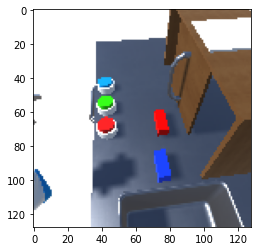

In [12]:
plt.imshow(shoulder_image)

In [16]:
i = 0
#p[-1] = 1.0
TIME_FREQUENCY = 25
reset_to(proprio[i,:], ags[i,:])

In [17]:


r = rospy.Rate(TIME_FREQUENCY) # 15hz 

env_reEngage_physics_pub.publish(Reengage())
#toggleTimePub.publish(Reengage(1))

In [18]:

env_reEngage_physics_pub.publish(Reengage())
t0 = time.time()
next_time = t0 + 1/TIME_FREQUENCY
#current_arm, current_ag, _,_,_,_ = process_observation()
while not rospy.is_shutdown() and i < 7022:

        # Triggers corelogic acting
        try:
            next_time = next_time + 1/TIME_FREQUENCY
            #current_arm, current_ag, sh,gr, _,_= process_observation_srv()
            
            #print(current_ag[-5:]-ags[i,-5:])
            print(achieved_goal[-2])#, current_ag[-1])
            time.sleep(AVG_MODEL_PROCESSING_TIME)

            clear_output(wait=True)
#             plt.imshow(shoulder_image)
#             plt.show()
            a = acts[i,:].copy()
            pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(acts[i,:]))


            i += 1
        except Exception as e:
            print(e)
            break
        r.sleep()
        
#toggleTimePub.publish(Reengage(0))

index 408 is out of bounds for axis 0 with size 408


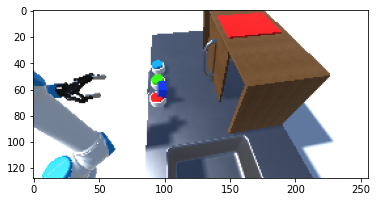

In [21]:
plt.imshow(shoulder_image)

# Ad - hoc analysis

In [94]:
for i in range(0,10):
    current_arm, current_ag, _,_, _,_= process_observation()
    print(current_arm[0:3], current_ag[-1])

[-0.54895222  0.32537282  0.61381531] -0.3325238823890686
[-0.55997694  0.32355946  0.6075967 ] -0.39987891912460327
[-0.5872699   0.32329878  0.60284889] -0.556308925151825
[-0.59185433  0.32096556  0.60017753] -0.5750659108161926
[-0.59349823  0.31970656  0.59891909] -0.5801215767860413
[-0.59428251  0.31918693  0.59830117] -0.5859288573265076
[-0.59465396  0.31882757  0.59797198] -0.5872109532356262
[-0.59480077  0.31886438  0.59782916] -0.5872884392738342
[-0.59485692  0.31887227  0.59777933] -0.5876383185386658
[-0.59488344  0.31887668  0.59775698] -0.5878576636314392


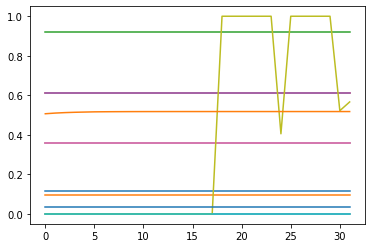

In [57]:
plt.plot(ags[7048:7080])

In [ ]:
y = 600
for i in range(y,y+100):
    print(i)
    reset_to(proprio[i,:], ags[i,:], acts[i,:])
    current_arm, current_ag, sh,gr, _ ,_= process_observation_srv()
    clear_output(wait=True)
    plt.imshow(sh)
#     plt.show()
#     plt.imshow(gr)
    plt.show()

600


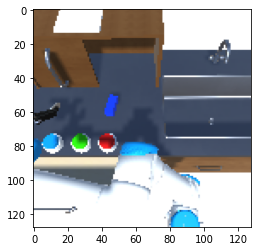

In [19]:
acts[0,:]

array([-0.58577919,  0.36473364,  0.36939099,  0.70868921, -0.42956665,
       -0.2921409 ,  0.        ])

In [58]:
#env_reEngage_pub.publish(Reengage())
i=0
r = rospy.Rate(5) # 15hz 
while not rospy.is_shutdown() and i < len(acts):
    try:
        pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(acts[i,:]))
        #env_reset_pub.publish(ag_to_ROSmsg(ags[i,:])) # shape (7,)
        i += 1
        print(i)
    except Exception as e:
        print(e)
        break
    r.sleep() # ros sleep for a little while before checking convergence again

expected [robotics_demo/JointPositions] but got [robotics_demo/AchievedGoal]


In [59]:
import time
for i in range(0, len(proprio)):
    reset_to(proprio[i,:], ags[i,:])
    #time.sleep(0.04)

In [35]:
proprio_rpy_to_ROSmsg(proprio[idx,:])

pos_x: -0.4428572952747345
pos_y: 0.22392550110816956
pos_z: 0.4295077919960022
rot_r: 0.6223673820495605
rot_p: -0.22585928440093994
rot_y: -0.1272006332874298
gripper: 0.9654262661933899

In [37]:
idx = 60
pos_cmd_pub.publish(proprio_rpy_to_ROSmsg(proprio[idx,:]))

In [ ]:
import matplotlib.pyplot as plt

In [29]:
thread = ServiceTimeouter(syncTimeServ, [time.time()])
thread.call()

t1 = time.time()

for i in range(0,5):
    tu = syncTimeServ(time.time()).time_rec/1000
    print(time.time(), tu)
t2 = time.time()
to_from = t2-t1
t_true = t1+to_from/2
t_offset = t_true - tu

    

t1 = time.time()

for i in range(0,5):
    tu = syncTimeServ(time.time()).time_rec/1000
    
t2 = time.time()
import matplotlib.pyplot as plt
plt.plot([t1, tu+t_offset, t2])
t1,tu+t_offset,t2, t_offset

263


In [26]:
t_offset = 0

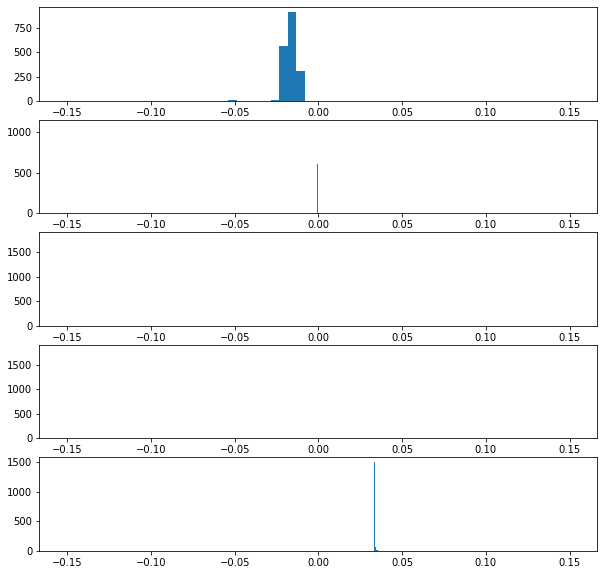

In [36]:
# 20 is the on beat
# What we can do is say the beat sent time is the 'centre', thats 0
# then the order should be data_arrival, beat_sent, act_begin, model_processed
# therefore we can create a histogram for each of these around 0

test = np.load(f"{OBS_ACT_PATH}/4/data.npz", allow_pickle=True)
obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
proprio = obs[:, :7]

ts, bs, dg, da, dp, ab, mp = [], [], [], [], [], [], []

for t in times:
    ts.append(t['timestep'])
    beat = t['beat_sent_time']
    bs.append(beat)
    da.append(t['data_arrival_time']- beat)
    dg.append((t['data_gen_time']/1000 + t_offset) - beat)
    dp.append(t['data_processed_time'] - beat)
    #bs.append(beat)
    ab.append(t['act_begin_time'] - beat)
    mp.append(t['model_processed_time'] - beat)
    
bbs = []
for i in range(0,len(times)-1):
    bbs.append(times[i+1]['model_processed_time'] - times[i]['model_processed_time'])
    
TIME_FREQUENCY = 12
fig, axs = plt.subplots(5, figsize =(10,10))
left, right = -1/TIME_FREQUENCY, 1/TIME_FREQUENCY
data = [dg,da,dp,ab,mp]
axs[0].hist(dg)
axs[1].hist(da)
axs[2].hist(dp)
axs[3].hist(ab)
axs[4].hist(mp)



for i in range(0,len(axs)):
    axs[i].set_xlim(left=left*2, right=right*2)

(array([279., 608., 454., 303., 144.,  31.,   3.,   1.,   1.,   5.]),
 array([0.03443527, 0.03994398, 0.04545269, 0.0509614 , 0.05647011,
        0.06197882, 0.06748753, 0.07299623, 0.07850494, 0.08401365,
        0.08952236]),
 <BarContainer object of 10 artists>)

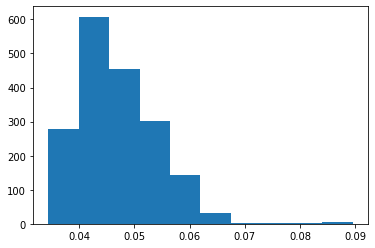

In [37]:
plt.hist(bbs)

In [38]:
len(bs)/(bs[-1] - bs[0])

21.38406601729198

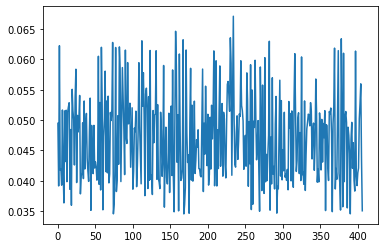

In [24]:
plt.plot(bbs)

In [23]:
ts = np.array(ts)
ts[1:200]-ts[0:135]

ValueError: operands could not be broadcast together with shapes (199,) (135,) 

(array([4232., 3552.,  622.,  945.,  239.,  261.,  125.,   12.,   12.,
           2.]),
 array([0.03398371, 0.03804913, 0.04211454, 0.04617996, 0.05024538,
        0.0543108 , 0.05837622, 0.06244164, 0.06650705, 0.07057247,
        0.07463789]),
 <BarContainer object of 10 artists>)

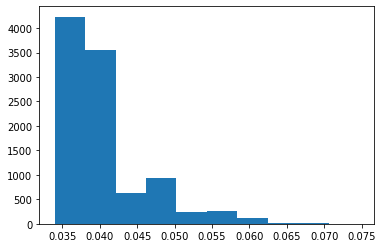

In [52]:
plt.hist(bbs)

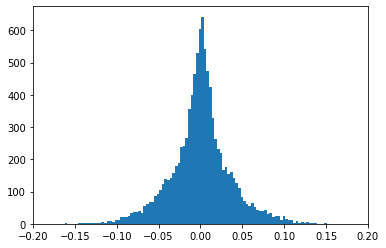

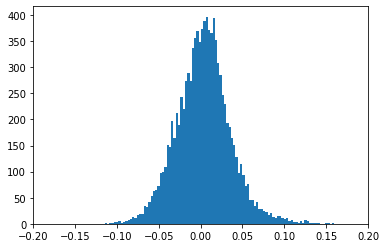

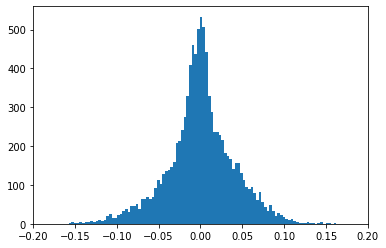

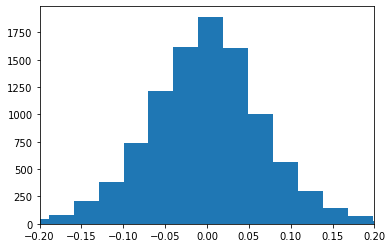

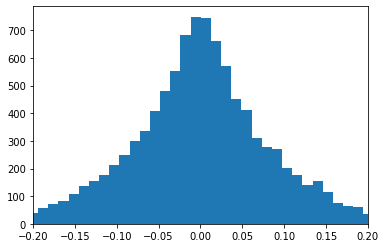

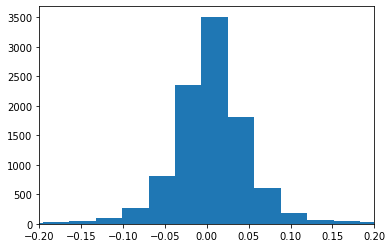

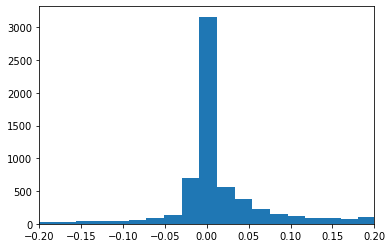

In [23]:
d = acts[:] - obs[:, :7]
for i in range(0, d.shape[1]):
    plt.hist(d[:,i], bins=100)
    #plt.hist(obs[:,i], bins=100, alpha=0.5)
    plt.xlim(-0.2,0.2)
    plt.show()

In [42]:
# d = d[1:] - d[:-1]\
import pybullet as p
def convert_to_rpy(arr, idx_pairs=[(3,7)]):
    a = []
    for i in range(0, len(arr)):
#         print([arr[i, :3], np.array(p.getEulerFromQuaternion(arr[i, 3:7])), arr[i, 7:]])
        a.append(np.concatenate([arr[i, :3], np.array(p.getEulerFromQuaternion(arr[i, 3:7])), arr[i, 7:]]))
    return np.vstack(a)

d = convert_to_rpy(ags)[:200]
d.shape
    

(200, 11)

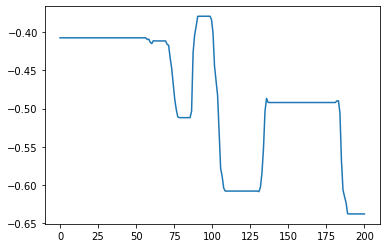

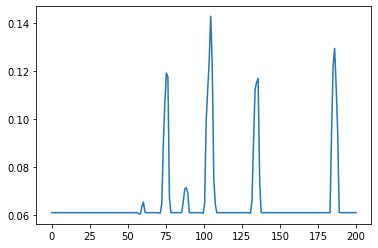

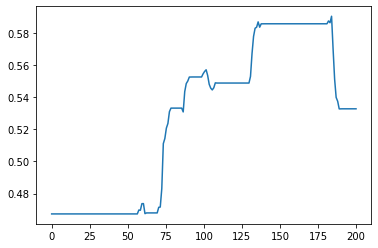

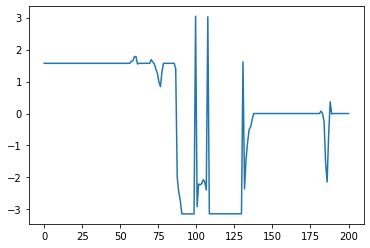

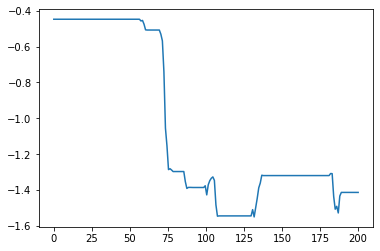

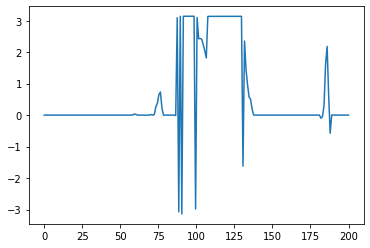

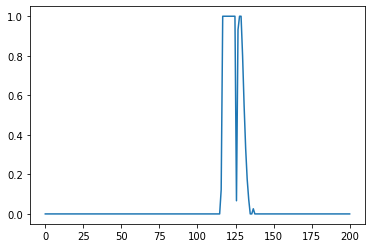

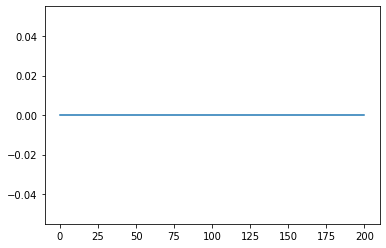

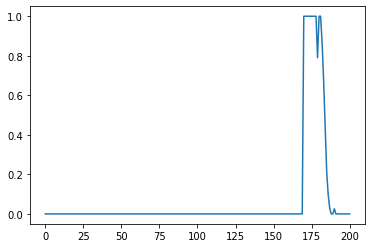

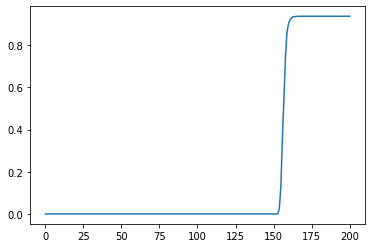

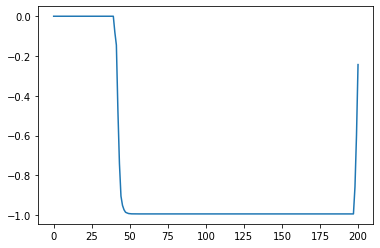

In [43]:
idx = np.random.randint(0, len(ags))
#d = ags[:, 3:6]
for i in range(0, d.shape[1]):
    plt.plot(np.linspace(0,len(d),len(d)), d[:,i])
    #plt.plot(np.linspace(0,len(acts),len(acts)), acts[:,i])
    plt.show()

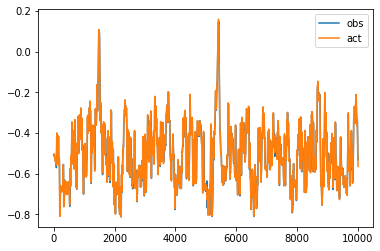

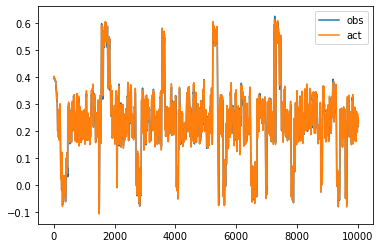

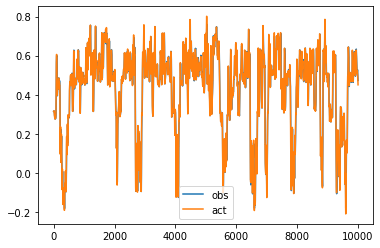

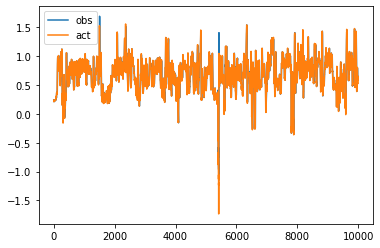

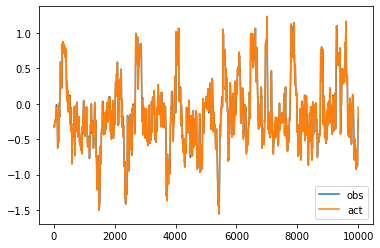

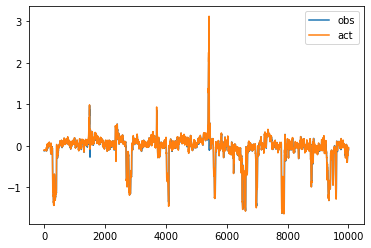

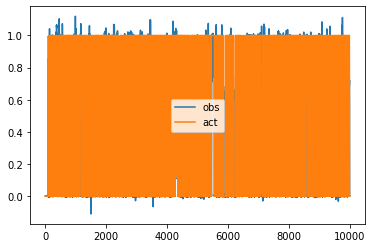

In [19]:
for i in range(0, 19):
    
    if i < 7:
        plt.plot(obs[0: , i])
        a = acts[0:,  i]
        #a = acts[100:185,  i]
        
        plt.plot(a)
#     if i >= 7:
#         plt.plot(ags[: , i-7])
        plt.legend(['obs', 'act'])
        plt.show()

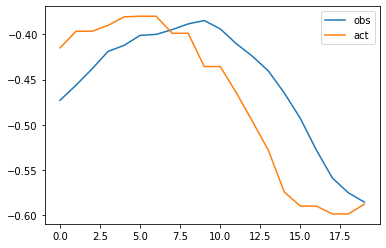

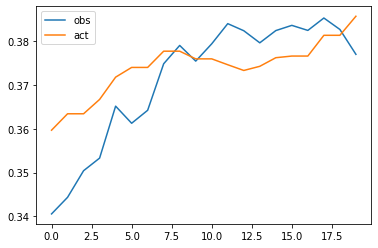

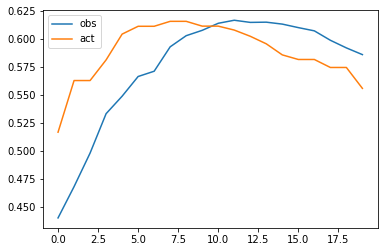

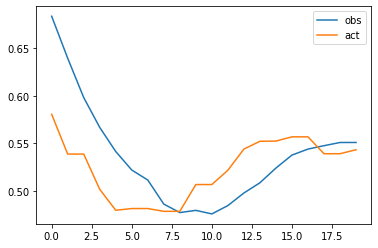

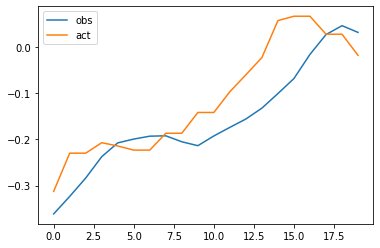

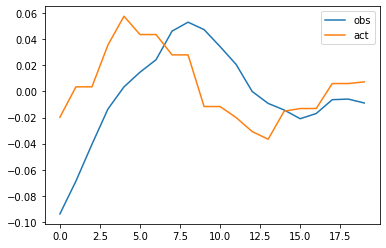

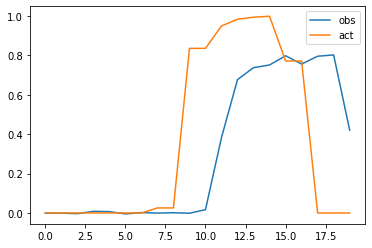

In [11]:

for i in range(0, 19):
    
    if i < 7:
        plt.plot(obs[60:80 , i])
        a = acts[60:80,  i]
        
        plt.plot(a)
#     if i >= 7:
#         plt.plot(ags[: , i-7])
        plt.legend(['obs', 'act'])
        plt.show()

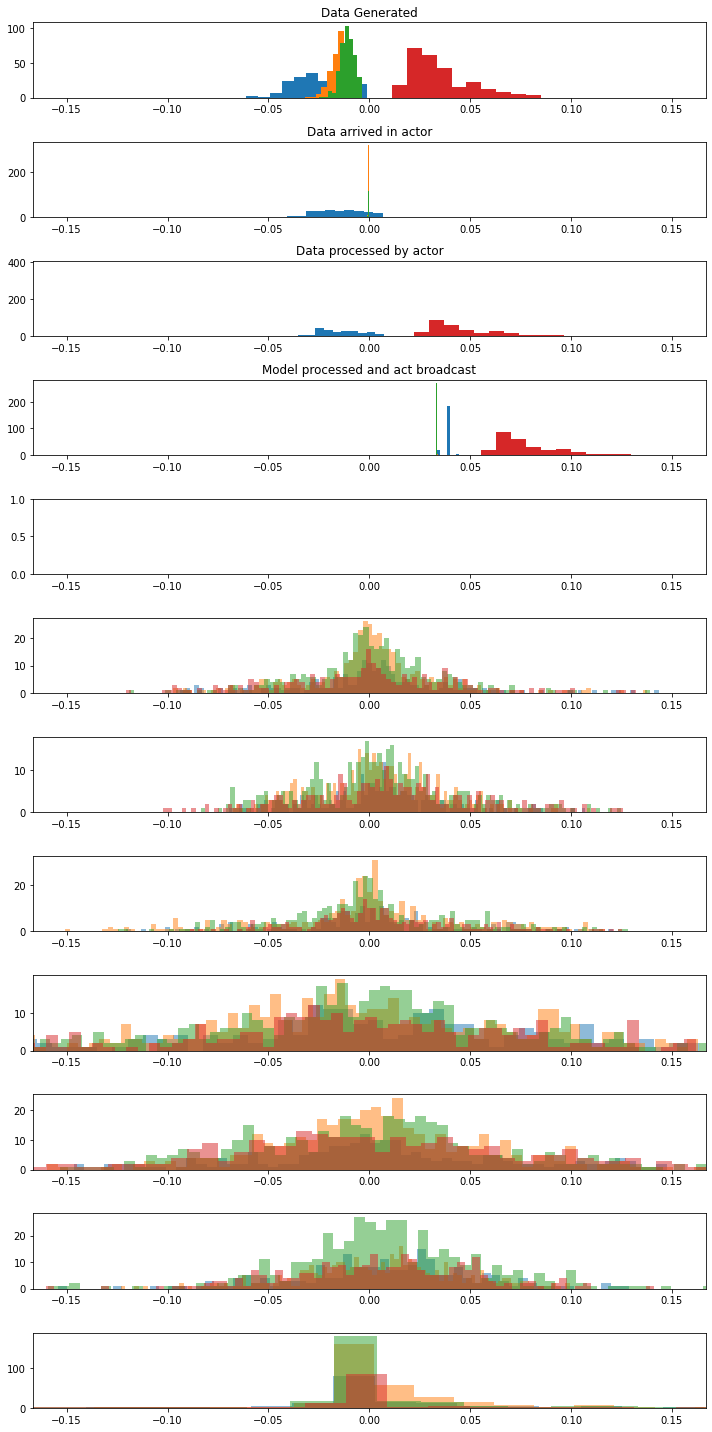

In [124]:


def compare(i, axs):
    test = np.load(f"{OBS_ACT_PATH}/{i}/data.npz", allow_pickle=True)
    obs, acts, ags, times = test['obs'], test['acts'], test['achieved_goals'], test['times']
    proprio = obs[:, :7]

    ts, bs, dg, da, dp, ab, mp = [], [], [], [], [], [], []

    for t in times:
        ts.append(t['timestep'])
        beat = t['beat_sent_time']
        bs.append(beat)
        da.append(t['data_arrival_time']- beat)
        dg.append((t['data_gen_time']/1000 + t_offset) - beat)
        dp.append(t['data_processed_time'] - beat)
        #bs.append(beat)
        ab.append(t['act_begin_time'] - beat)
        mp.append(t['model_processed_time'] - beat)

    bbs = []
    for i in range(0,len(times)-1):
        bbs.append(times[i+1]['model_processed_time'] - times[i]['model_processed_time'])

    TIME_FREQUENCY = 12
    
    left, right = -1/TIME_FREQUENCY, 1/TIME_FREQUENCY
    axs[0].hist(np.array(dg)+0.05), axs[0].set_title('Data Generated')
    axs[1].hist(da), axs[1].set_title('Data arrived in actor')
    axs[2].hist(dp), axs[2].set_title('Data processed by actor')
    #axs[3].hist(ab), axs[0].set_title('Data Generated')
    axs[3].hist(mp), axs[3].set_title('Model processed and act broadcast')

    for i in range(0,len(axs)):
        axs[i].set_xlim(left=left*2, right=right*2)
        
        
        
    d = acts[:] - obs[:, :7]
    for i in range(0, d.shape[1]):
        axs[5+i].hist(d[:,i], bins=100, alpha=0.5)
        

fig, axs = plt.subplots(12, figsize =(10,20))
compare(0, axs), compare(1, axs), compare(2, axs), compare(3, axs)
plt.tight_layout()

In [26]:
mins = np.min(ag, axis = 0)
maxes = np.max(ag, axis = 0)
bins = np.linspace(mins,maxes+0.01, 11)

idx = 0
qs = []
for idx in range(0,ag.shape[1]):
    quantiles = np.digitize(ag[:,idx], bins[:,idx])
    qs.append(quantiles)
qs = np.array(qs).T
qs.shape
np.unique(qs, axis=0).shape[0]

22274

In [27]:
from tqdm import tqdm
step2 = []
count2 = []
for i in tqdm(np.linspace(1, len(qs), 10)):
    
    i = int(i)
    step2.append(i)
    
    count2.append(np.unique(qs[:i], axis=0).shape[0])

100%|██████████| 10/10 [00:02<00:00,  4.38it/s]


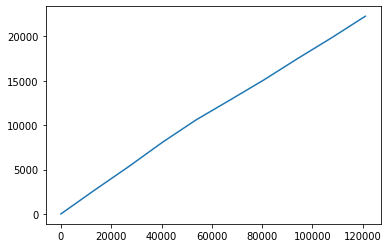

In [28]:
import matplotlib.pyplot as plt
#plt.plot(step, count)
plt.plot(step2, count2)